<a href="https://colab.research.google.com/github/areegtarek/Sentiment-Analysis-of-Earnings-Call-Transcripts-using-BERT/blob/main/Sentiment_Analysis_using_FINBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment Analysis of Earnings Call Transcripts using BERT**

The goal of this project is using a fine-tuned sentiment analysis BERT model to determine if management sentiment expressed in earnings call transcripts is positive or negative.

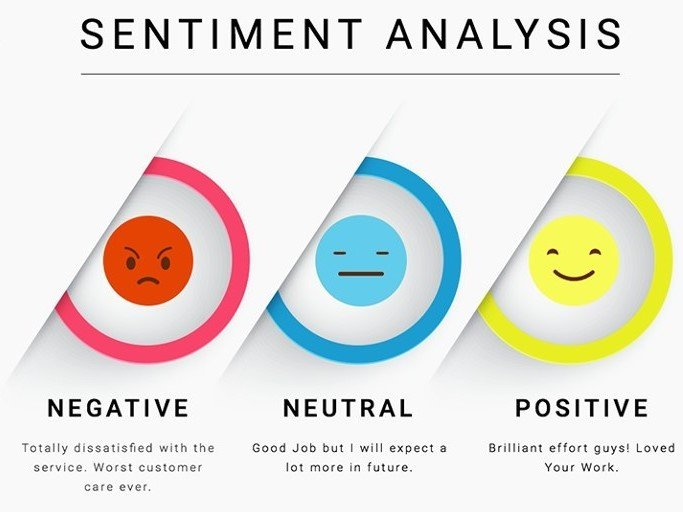

# **Data Description**

dataset contains earnings call transcripts that were scraped from Motley Fool. Each row represents a single earnings call transcript.

**The columns are:**

- **date:** Date and time of the earnings call.
- **exchange:** Stock exchange where the company is listed, e.g. NASDAQ, NYSE.
- **q:** Quarter being reported on, e.g. 2020-Q2.
- **ticker:** Stock ticker symbol of the company.
- **transcript:** Full text of the earnings call transcript.

# **Importing Necessary Libraries and datasets**

In [ ]:
!pip install transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
!pip install wordcloud

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
'''# Install kaggle API
! pip install -q kaggle'''

'# Install kaggle API\n! pip install -q kaggle'

In [ ]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import re
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm

**upload kaggle API key to colab notebook**

In [ ]:
'''# Make directory named kaggle and copy kaggle.json file there
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/'''

'# Make directory named kaggle and copy kaggle.json file there\n! mkdir ~/.kaggle\n! cp kaggle.json ~/.kaggle/'

In [ ]:
'''# disable API key
! chmod 600 /root/.kaggle/kaggle.json'''

'# disable API key\n! chmod 600 /root/.kaggle/kaggle.json'

In [ ]:
'''# import the dataset
!kaggle datasets download -d tpotterer/motley-fool-scraped-earnings-call-transcripts'''

'# import the dataset\n!kaggle datasets download -d tpotterer/motley-fool-scraped-earnings-call-transcripts'

In [ ]:
'''# unzipping the dataset
! unzip -q motley-fool-scraped-earnings-call-transcripts.zip'''

'# unzipping the dataset\n! unzip -q motley-fool-scraped-earnings-call-transcripts.zip'

# **Data Exploration**

In [ ]:
df= pd.read_pickle('motley-fool-data.pkl')

In [ ]:
df.head()

,date,exchange,q,ticker,transcript
0,"Aug 27, 2020, 9:00 p.m. ET",NASDAQ: BILI,2020-Q2,BILI,"Prepared Remarks:\nOperator\nGood day, and wel..."
1,"Jul 30, 2020, 4:30 p.m. ET",NYSE: GFF,2020-Q3,GFF,Prepared Remarks:\nOperator\nThank you for sta...
2,"Oct 23, 2019, 5:00 p.m. ET",NASDAQ: LRCX,2020-Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...
3,"Nov 6, 2019, 12:00 p.m. ET",NASDAQ: BBSI,2019-Q3,BBSI,"Prepared Remarks:\nOperator\nGood day, everyon..."
4,"Aug 7, 2019, 8:30 a.m. ET",NASDAQ: CSTE,2019-Q2,CSTE,Prepared Remarks:\nOperator\nGreetings and wel...


In [ ]:
df.shape

(18755, 5)

In [ ]:
df.columns

Index(['date', 'exchange', 'q', 'ticker', 'transcript'], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18755 entries, 0 to 18754
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        18755 non-null  object
 1   exchange    18755 non-null  object
 2   q           18755 non-null  object
 3   ticker      18755 non-null  object
 4   transcript  18755 non-null  object
dtypes: object(5)
memory usage: 732.7+ KB


In [ ]:
# statistical summary
df.describe(include='all').T

,count,unique,top,freq
date,18755,6059,"Nov 4, 2021, 5:00 p.m. ET",53
exchange,18755,2879,NASDAQ: AAPL,62
q,18755,25,2021-Q3,2439
ticker,18755,2876,AAPL,62
transcript,18755,17592,Prepared Remarks:\nOperator\nLadies and gentle...,32


## **transcript**

In [ ]:
df['transcript'][0]

"Prepared Remarks:\nOperator\nGood day, and welcome to the Bilibili 2020 Second Quarter Earnings Conference Call. Today's conference is being recorded.\nAt this time, I would like to turn the conference over to Juliet Yang, Senior Director of Investor Relations. Please go ahead.\nJuliet Yang -- Senior Director of Investor Relations\nThank you, operator.\nPlease note the discussion today will contain forward-looking statements relating to the Company's future performance, and are intended to qualify for the Safe Harbor from liability, as established by the US Private Securities Litigation Reform Act. Such statements are not guarantees of future performance and are subject to certain risks and uncertainties, assumptions and other factors. Some of these risks are beyond the Company's control and could cause actual results to differ materially from those mentioned in today's press release and this discussion. A general discussion of the risk factors that could affect Bilibili's business an

In [ ]:
transcript_lengths = [len(transcript) for transcript in df['transcript']]

# Calculate statistics
min_length = np.min(transcript_lengths)
max_length = np.max(transcript_lengths)
mean_length = np.mean(transcript_lengths)
std_deviation = np.std(transcript_lengths)
percentiles = np.percentile(transcript_lengths, [25, 50, 75])

# Print statistics
print(f"Minimum Length: {min_length}")
print(f"Maximum Length: {max_length}")
print(f"Mean Length: {mean_length}")
print(f"Standard Deviation: {std_deviation}")
print(f"25th Percentile: {percentiles[0]}")
print(f"50th Percentile (Median): {percentiles[1]}")
print(f"75th Percentile: {percentiles[2]}")

Minimum Length: 3616
Maximum Length: 188514
Mean Length: 47303.002452679284
Standard Deviation: 14686.082802794277
25th Percentile: 37153.5
50th Percentile (Median): 47930.0
75th Percentile: 56945.0


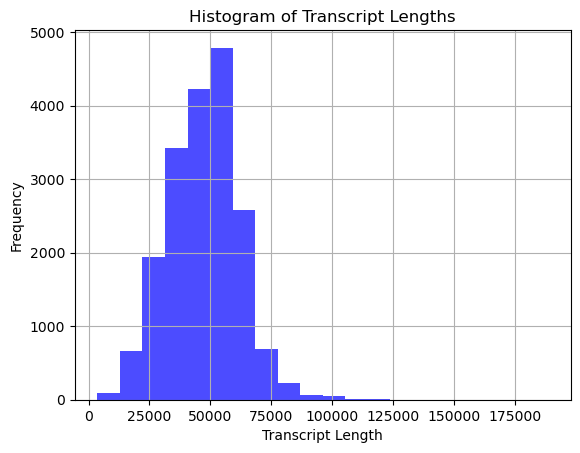

In [ ]:
# Plot histogram
plt.hist(transcript_lengths, bins=20, color='blue', alpha=0.7)
plt.title("Histogram of Transcript Lengths")
plt.xlabel("Transcript Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

- Transcripts vary significantly in length, from a few thousand words up to over 185,000 words.
- On average, transcripts are quite long at over 47,000 words.
- There is substantial variability in lengths around the mean.
- The median and percentiles demonstrate the spread of lengths.
- This length variability could impact modeling if it's not properly accounted for. Preprocessing may need to handle very long and short transcripts differently.

# **Sentimentent Analysis using FinBert**

we will use FinBert, a version of BERT that has been specifically fine-tuned on financial text corpora, to build a sentiment analysis model for classifying the sentiment expressed in earnings call transcripts as positive or negative.

In [ ]:
#work on sample
df_sample = df.sample(frac=0.01,random_state=1)
df_sample

,date,exchange,q,ticker,transcript
6197,"Jul 23, 2021, 10:00 a.m. ET",NYSE: RNR,2021-Q2,RNR,Prepared Remarks:\nOperator\nGood day and than...
1728,"May 10, 2021, 5:00 p.m. ET",NYSE: MODG,2021-Q1,MODG,Prepared Remarks:\nOperator\nGood day and than...
792,"Aug 03, 2022, 8:00 a.m. ET",NASDAQ: LAMR,2022-Q2,LAMR,"Prepared Remarks:\nOperator\nExcuse me, everyo..."
8775,"Apr 15, 2021, 10:00 a.m. ET",NASDAQ: CVAC,2020-Q4,CVAC,Prepared Remarks:\nSarah Fakih\nThank you. Goo...
5789,"Oct 28, 2020, 8:30 a.m. ET",NYSE: ACCO,2020-Q3,ACCO,Prepared Remarks:\nOperator\nLadies and gentle...
...,...,...,...,...,...
516,"Dec 22, 2020, 9:00 a.m. ET",NYSE: KMX,2021-Q3,KMX,Prepared Remarks:\nOperator\nGood morning. My ...
15395,"Aug 6, 2021, 9:00 a.m. ET",NYSE: BKD,2021-Q2,BKD,Prepared Remarks:\nKathy MacDonald -- Senior V...
17562,"Mar 01, 2022, 5:00 p.m. ET",NASDAQ: BGFV,2021-Q4,BGFV,"Prepared Remarks:\nOperator\nGood day, ladies ..."
10278,"Feb 10, 2021, 5:00 p.m. ET",NASDAQ: SSNC,2020-Q4,SSNC,Prepared Remarks:\nOperator\nLadies and gentle...


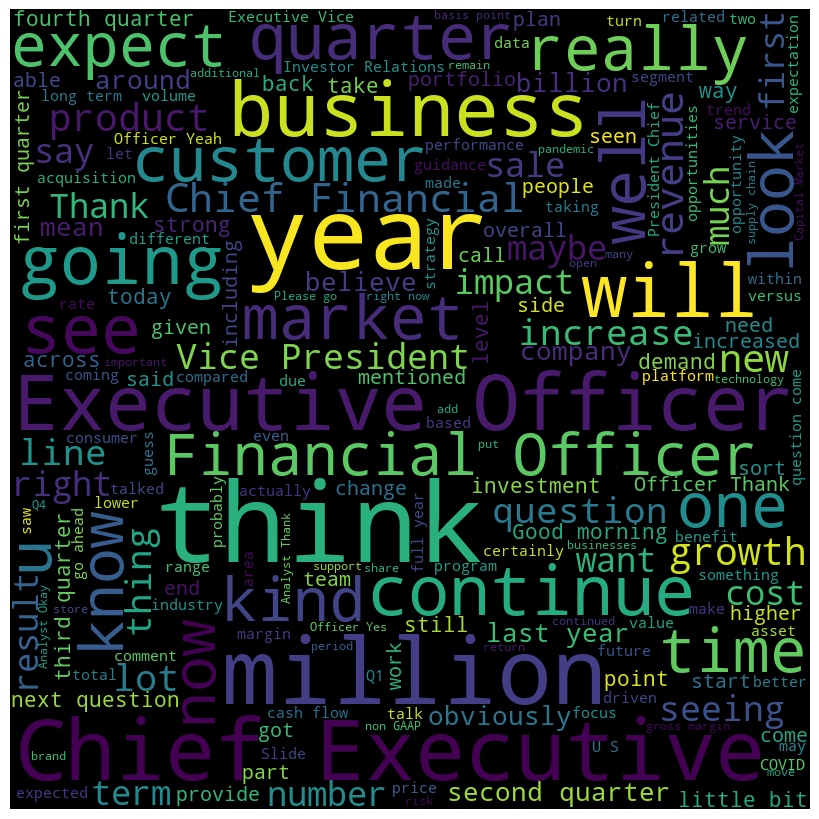

In [ ]:
# Combine all transcripts into a single string
text = ' '.join(df_sample['transcript'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=800, random_state=21, max_font_size=110).generate(text)

# Plot the wordcloud
plt.figure(figsize=(10, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

In [ ]:
transcript_lengths = [len(transcript) for transcript in df_sample['transcript']]

# Calculate statistics
min_length = np.min(transcript_lengths)
max_length = np.max(transcript_lengths)
mean_length = np.mean(transcript_lengths)
std_deviation = np.std(transcript_lengths)
percentiles = np.percentile(transcript_lengths, [25, 50, 75])

# Print statistics
print(f"Minimum Length: {min_length}")
print(f"Maximum Length: {max_length}")
print(f"Mean Length: {mean_length}")
print(f"Standard Deviation: {std_deviation}")
print(f"25th Percentile: {percentiles[0]}")
print(f"50th Percentile (Median): {percentiles[1]}")
print(f"75th Percentile: {percentiles[2]}")

Minimum Length: 7258
Maximum Length: 84894
Mean Length: 46817.76063829787
Standard Deviation: 13762.290887009454
25th Percentile: 36752.25
50th Percentile (Median): 47450.5
75th Percentile: 56446.25


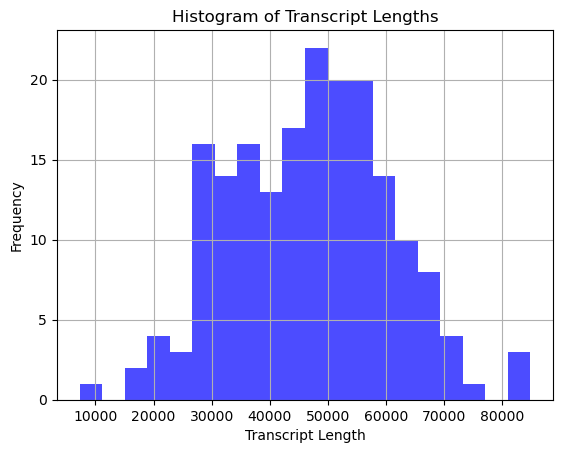

In [ ]:
# Plot histogram
plt.hist(transcript_lengths, bins=20, color='blue', alpha=0.7)
plt.title("Histogram of Transcript Lengths")
plt.xlabel("Transcript Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# **FinBert Inference**

In [ ]:
#Getting the tokenizer and the model

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

## **1- Trail**

we will directly apply FinBert on the raw, unprocessed earnings call transcripts without performing any preprocessing steps.

In [ ]:
transcript_array = np.array(df_sample['transcript'])
transcript_list = list(transcript_array)

len(transcript_list)

188

In [ ]:
#That's where the headlines get tokenized to be inputted into model

inputs = tokenizer(transcript_list, padding = True, truncation = True, return_tensors='pt')
print(inputs)

{'input_ids': tensor([[  101,  4810, 12629,  ...,  2005,  1996,   102],
        [  101,  4810, 12629,  ...,  6581,  1053,   102],
        [  101,  4810, 12629,  ...,  2583,  2000,   102],
        ...,
        [  101,  4810, 12629,  ...,  1045,  2323,   102],
        [  101,  4810, 12629,  ..., 16313,  2850,   102],
        [  101,  4810, 12629,  ...,  2744,  3643,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])}


In [ ]:
#inference

outputs = model(**inputs)
print(outputs.logits.shape)

torch.Size([188, 3])


In [ ]:
#Postprocessing with softmax

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[0.1468, 0.0122, 0.8410],
        [0.0403, 0.0204, 0.9392],
        [0.8832, 0.0537, 0.0631],
        [0.1786, 0.0102, 0.8112],
        [0.0266, 0.0458, 0.9275],
        [0.0267, 0.0352, 0.9380],
        [0.0482, 0.0212, 0.9306],
        [0.1062, 0.0122, 0.8816],
        [0.2278, 0.1593, 0.6130],
        [0.2153, 0.0177, 0.7670],
        [0.7770, 0.0117, 0.2114],
        [0.6940, 0.0126, 0.2934],
        [0.0800, 0.0196, 0.9004],
        [0.0307, 0.0352, 0.9341],
        [0.0472, 0.0153, 0.9376],
        [0.1657, 0.0139, 0.8204],
        [0.0527, 0.0254, 0.9219],
        [0.0442, 0.0213, 0.9345],
        [0.1370, 0.0113, 0.8518],
        [0.0507, 0.0363, 0.9130],
        [0.4084, 0.0784, 0.5132],
        [0.0220, 0.0316, 0.9463],
        [0.0813, 0.0209, 0.8978],
        [0.0538, 0.0160, 0.9301],
        [0.0384, 0.0298, 0.9318],
        [0.1000, 0.0543, 0.8457],
        [0.0276, 0.0288, 0.9436],
        [0.0628, 0.0140, 0.9232],
        [0.0351, 0.0318, 0.9331],
        [0.031

In [ ]:
#Model classes

model.config.id2label

{0: 'positive', 1: 'negative', 2: 'neutral'}

In [ ]:
#Headline #Positive #Negative #Neutral
positive = predictions[:, 0].tolist()
negative = predictions[:, 1].tolist()
neutral = predictions[:, 2].tolist()

table = {'transcript':transcript_list,
         "Positive":positive,
         "Negative":negative,
         "Neutral":neutral}

df_SA = pd.DataFrame(table, columns = ["transcript", "Positive", "Negative", "Neutral"])

df_SA

,transcript,Positive,Negative,Neutral
0,Prepared Remarks:\nOperator\nGood day and than...,0.146805,0.012227,0.840967
1,Prepared Remarks:\nOperator\nGood day and than...,0.040336,0.020439,0.939225
2,"Prepared Remarks:\nOperator\nExcuse me, everyo...",0.883196,0.053692,0.063113
3,Prepared Remarks:\nSarah Fakih\nThank you. Goo...,0.178596,0.010163,0.811241
4,Prepared Remarks:\nOperator\nLadies and gentle...,0.026647,0.045816,0.927536
...,...,...,...,...
183,Prepared Remarks:\nOperator\nGood morning. My ...,0.128731,0.014064,0.857205
184,Prepared Remarks:\nKathy MacDonald -- Senior V...,0.565766,0.014066,0.420169
185,"Prepared Remarks:\nOperator\nGood day, ladies ...",0.533206,0.014193,0.452601
186,Prepared Remarks:\nOperator\nLadies and gentle...,0.181714,0.041292,0.776995


In [ ]:
pos_count = 0
neg_count = 0
neu_count = 0

for index, row in df_SA.iterrows():
    if row['Positive'] > row['Negative'] and row['Positive'] > row['Neutral']:
        pos_count += 1
    elif row['Negative'] > row['Positive'] and row['Negative'] > row['Neutral']:
        neg_count += 1
    else:
        neu_count += 1

print(f'Positive transcripts: {pos_count}')
print(f'Negative transcripts: {neg_count}')
print(f'Neutral transcripts: {neu_count}')

Positive transcripts: 31
Negative transcripts: 2
Neutral transcripts: 155


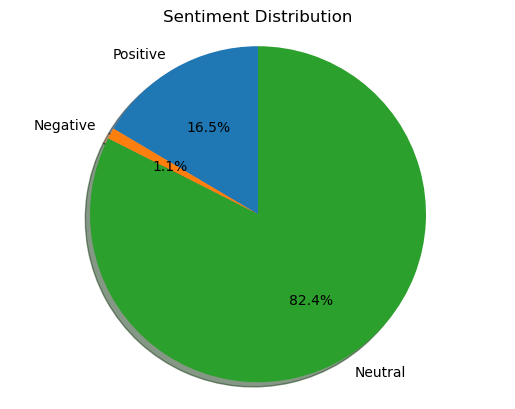

In [ ]:
labels = ['Positive', 'Negative', 'Neutral']
sizes = [pos_count, neg_count, neu_count]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.title('Sentiment Distribution')
plt.savefig('sentiment_pie_chart.png')
plt.show()

The vast majority of transcripts were labeled as neutral, likely due to the unstructured nature of the verbatim text containing natural discussions and greetings in addition to analysis of financial results.

## **2- Trail**

We then preprocessed the transcripts to extract only the sentences containing financial information and metrics. This involved removing greetings, acknowledgments and unrelated discussions.

In [ ]:
regex = r"\n(?:[^\.!?]+\b(?:revenue|expenses|profit|earnings|net|income|cash|flow|operating|assets|liabilities|equity|EBITDA|gross|growth|prescriptions|rates|rate|inventory|accounts|receivable|lower|Expect|capital|receivable|sales|raised|higher|interest|debt|expense|reduction|paid|demand|stocking|collaboration|expect|costs|increased|decreased|stock|price|quarter|impact|year|question|compared|need|term|coming|muchmentioned|business|segment|investor|probably|[A-Z]+)\b[^\.!?]*[\.!?])"
df_sample['matches'] = [re.findall(regex, text) for text in df_sample['transcript']]

In [ ]:
# Define the pattern
pattern = r'\[([^\]]+)\]'

# Apply the regex substitution to the 'matches' column in the DataFrame
df_sample['matches'] = df_sample['matches'].apply(lambda x: re.sub(pattern, r'\1', str(x)))

In [ ]:
df_sample['matches'][8775]

'\'\\nLet me begin by giving you an overview of selected key highlights in 2020 and of the success we were able to achieve since the beginning of this year.\', \'\\nWe are further expanding the COVID-19 vaccine program and are expecting to initiate three clinical trials soon.\', \'\\nFollowing the promising results announced in the third quarter of 2020, the expansion of the Phase 1 trial aims to confirm the safety and preliminary efficacy of CV8102 at a selected dose of 600 micrograms.\', \'\\nWe reaffirm our anticipated manufacturing capacity for 2021 of up to 300 million dosages produced and have raised our manufacturing guidance for 2022 to 1 billion doses of CVnCoV.\', \'\\nWe believe that this progress has put us into an optimal position to further grow the business and accelerate our corporate transformation and development from a biotech into a commercial biopharma company.\', \'\\nMoving into 2021, we continue to transform as a business and move toward executing on our core ma

In [ ]:
transcript_lengths = [len(transcript) for transcript in df_sample['matches']]

# Calculate statistics
min_length = np.min(transcript_lengths)
max_length = np.max(transcript_lengths)
mean_length = np.mean(transcript_lengths)
std_deviation = np.std(transcript_lengths)
percentiles = np.percentile(transcript_lengths, [25, 50, 75])

# Print statistics
print(f"Minimum Length: {min_length}")
print(f"Maximum Length: {max_length}")
print(f"Mean Length: {mean_length}")
print(f"Standard Deviation: {std_deviation}")
print(f"25th Percentile: {percentiles[0]}")
print(f"50th Percentile (Median): {percentiles[1]}")
print(f"75th Percentile: {percentiles[2]}")

Minimum Length: 1003
Maximum Length: 17709
Mean Length: 7604.824468085107
Standard Deviation: 2945.049025354542
25th Percentile: 5332.0
50th Percentile (Median): 7532.5
75th Percentile: 9713.25


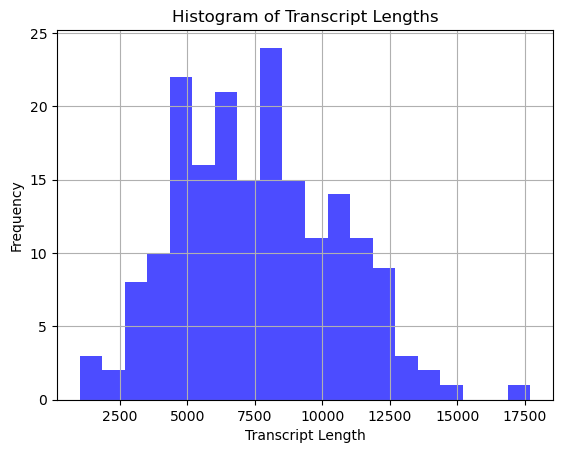

In [ ]:
# Plot histogram
plt.hist(transcript_lengths, bins=20, color='blue', alpha=0.7)
plt.title("Histogram of Transcript Lengths")
plt.xlabel("Transcript Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
# Combine all transcripts into a single string
text = ' '.join(df_sample['matches'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=800, random_state=21, max_font_size=110).generate(text)

# Plot the wordcloud
plt.figure(figsize=(10, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

In [ ]:
text=df_sample['matches']

In [ ]:
transcript_array = np.array(text)
transcript_list = list(transcript_array)

len(transcript_list)

In [ ]:
#That's where the headlines get tokenized to be inputted into model

inputs = tokenizer(transcript_list, padding = True, truncation = True, return_tensors='pt')

print(inputs)

In [ ]:
#inference

outputs = model(**inputs)
print(outputs.logits.shape)

torch.Size([188, 3])


In [ ]:
#Postprocessing with softmax
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[0.3834, 0.0224, 0.5942],
        [0.9264, 0.0108, 0.0628],
        [0.9485, 0.0149, 0.0366],
        [0.4220, 0.0119, 0.5661],
        [0.1694, 0.7697, 0.0609],
        [0.1131, 0.7251, 0.1618],
        [0.6614, 0.0094, 0.3292],
        [0.9399, 0.0246, 0.0355],
        [0.8595, 0.0087, 0.1318],
        [0.2273, 0.0115, 0.7612],
        [0.8757, 0.0100, 0.1142],
        [0.2773, 0.0101, 0.7126],
        [0.7215, 0.1676, 0.1109],
        [0.9224, 0.0261, 0.0514],
        [0.0863, 0.0149, 0.8987],
        [0.2545, 0.0144, 0.7311],
        [0.4988, 0.0105, 0.4907],
        [0.8954, 0.0078, 0.0968],
        [0.8879, 0.0097, 0.1025],
        [0.0126, 0.9482, 0.0392],
        [0.3882, 0.5671, 0.0446],
        [0.0228, 0.0256, 0.9516],
        [0.4841, 0.0139, 0.5020],
        [0.8389, 0.0167, 0.1444],
        [0.1243, 0.0094, 0.8663],
        [0.3607, 0.5887, 0.0506],
        [0.8063, 0.0080, 0.1857],
        [0.7877, 0.0103, 0.2019],
        [0.3700, 0.0110, 0.6190],
        [0.775

In [ ]:
#Model classes

model.config.id2label

{0: 'positive', 1: 'negative', 2: 'neutral'}

In [ ]:
#Headline #Positive #Negative #Neutral
positive = predictions[:, 0].tolist()
negative = predictions[:, 1].tolist()
neutral = predictions[:, 2].tolist()

table = {'transcript':transcript_list,
         "Positive":positive,
         "Negative":negative,
         "Neutral":neutral}

df_SA_t = pd.DataFrame(table, columns = ["transcript", "Positive", "Negative", "Neutral"])

df_SA_t

,transcript,Positive,Negative,Neutral
0,'\nI would now like to hand the conference ove...,0.383404,0.022440,0.594157
1,"""\nToday, the company issued a press release a...",0.926385,0.010794,0.062821
2,"""\nLamar has identified important factors that...",0.948464,0.014921,0.036615
3,'\nLet me begin by giving you an overview of s...,0.422008,0.011877,0.566115
4,"""\nOperator\nLadies and gentlemen, thank you f...",0.169387,0.769734,0.060879
...,...,...,...,...
183,"""\nLet me remind you, our statements today reg...",0.312985,0.511401,0.175614
184,"'\nNow, I will turn the call over to Cindy.', ...",0.923802,0.019065,0.057133
185,"'\nWith that balance sheet strength, we have t...",0.075664,0.878581,0.045755
186,"'\nOperator\nLadies and gentlemen, thank you f...",0.024856,0.915266,0.059878


In [ ]:
pos_count = 0
neg_count = 0
neu_count = 0

for index, row in df_SA_t.iterrows():
    if row['Positive'] > row['Negative'] and row['Positive'] > row['Neutral']:
        pos_count += 1
    elif row['Negative'] > row['Positive'] and row['Negative'] > row['Neutral']:
        neg_count += 1
    else:
        neu_count += 1

print(f'Positive transcripts: {pos_count}')
print(f'Negative transcripts: {neg_count}')
print(f'Neutral transcripts: {neu_count}')

Positive transcripts: 115
Negative transcripts: 24
Neutral transcripts: 49


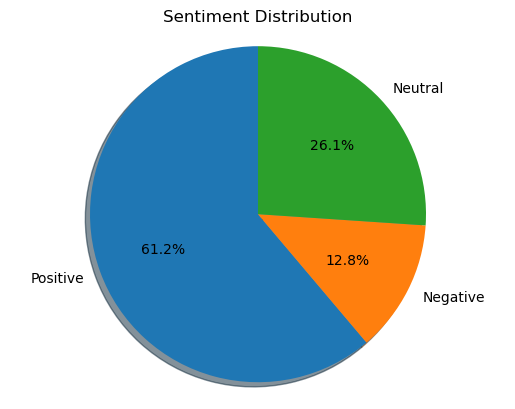

In [ ]:
labels = ['Positive', 'Negative', 'Neutral']
sizes = [pos_count, neg_count, neu_count]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.title('Sentiment Distribution')
plt.savefig('sentiment_pie_chart.png')
plt.show()

The preprocessing step of isolating financial sentences clearly helped FinBERT better focus its analysis by removing extraneous content. This led to a much more balanced classification with far fewer transcripts labeled neutral.

In [ ]:
#df_SA_t.to_csv('stock_price.csv')

In [ ]:
#df_sample.to_csv('full_sample.csv')

# **Conclusion**

- Preprocessing the transcripts to isolate only the financial metric sentences was important for focusing FinBERT's analysis and avoiding overly neutral classifications.

- Going forward, combining FinBERT with additional preprocessing techniques like named entity recognition could help extract even more relevant financial details and metrics for sentiment analysis.

- Larger financial corpora would likely help FinBERT further improve its performance on this financial domain text over time.

- Applying sentiment analysis to earnings calls has potential usefulness for investors and analysts seeking insights into management's subjective views beyond just the reported numbers.

- Further research could explore classification of sentiment at a more granular sentence or phrase level, rather than just classifying the whole transcript.

- Comparisons with other pretrained language models fine-tuned on financial language would help determine the current state-of-the-art for this earnings call sentiment analysis task.